# Airbnb Capstone Project

## 1.Import all Libraries

In [1]:
### import all libraries and set settings 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import gzip
import pyproj
import math

from py_functions import increase_bbox 
from sklearn.neighbors import BallTree
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import transform
from functools import partial

pd.set_option('display.max_columns', None) # show all columns  

## 2.Inside Airbnb pipeline

In [2]:
### Define path, .gz archive file name, country and city for url
path ='data/'
gz_file = "listings.csv.gz"
country = "united-kingdom"
state = "england"
city = "london"
url = f"http://data.insideairbnb.com/{country}/{state}/{city}/2023-03-14/data/{gz_file}"

In [3]:
### Create new directory for city
!mkdir {path}{city}

mkdir: data/london: File exists


In [4]:
### Download the .gz file
r = requests.get(url)
with open(path+city+'/'+gz_file, 'wb') as f:
    f.write(r.content)

In [5]:
### Unzip the .gz file and save the content as pd.DataFrame via read_csv
with gzip.open(path+city+'/'+gz_file) as f:
    listings = pd.read_csv(f)


In [6]:
### select only desired columns 
columns_keeper = (["id",
                   "listing_url",
                   "name",
                   "picture_url",
                   "host_id",
                   "host_response_rate",
                   "host_acceptance_rate",
                   "host_is_superhost",
                   "host_listings_count",
                   "host_total_listings_count",
                   "neighbourhood_cleansed",
                   "latitude",
                   "longitude",
                   "room_type",
                   "accommodates",
                   "bathrooms_text",
                   "bedrooms",
                   "beds",
                   "amenities",
                   "price",
                   "minimum_nights",
                   "maximum_nights",
                   "instant_bookable",
                   "number_of_reviews",
                   "number_of_reviews_ltm",
                   "number_of_reviews_l30d",
                   "first_review",
                   "last_review",
                   "review_scores_rating",
                   "review_scores_accuracy",
                   "review_scores_cleanliness",
                   "review_scores_checkin",
                   "review_scores_communication",
                   "review_scores_location",
                   "review_scores_value",
                   "reviews_per_month"]
                  )

In [7]:
### filter columns 
listings_short = listings[columns_keeper]

### 2.2.First Look - Airbnb Data

In [8]:
listings_short.head()

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,f,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1 shared bath,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",$100.00,1,365,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100%,100%,f,14.0,31.0,Barnet,51.636518,-0.177475,Entire home/apt,1,1 bath,1.0,1.0,[],$65.00,180,365,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,822557738577472503,https://www.airbnb.com/rooms/822557738577472503,PropertyPlug - 2Bed Flat in Edgware SmartTV WiFi,https://a0.muscache.com/pictures/d77957d5-695a...,325629338,100%,91%,t,4.0,8.0,Harrow,51.608180,-0.277400,Entire home/apt,4,2 baths,2.0,2.0,"[""Dining table"", ""Washer"", ""Outdoor furniture""...",$132.00,2,28,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3518856,https://www.airbnb.com/rooms/3518856,Wimbledon Double Bedroom Ensuite,https://a0.muscache.com/pictures/23a18442-fc1d...,187811,NaN,100%,f,2.0,5.0,Merton,51.422310,-0.188410,Private room,1,1 private bath,1.0,1.0,"[""Washer"", ""Iron"", ""Hangers"", ""Kitchen"", ""Smok...",$100.00,5,1125,f,4,0,0,2015-12-27,2016-07-11,3.67,3.0,4.33,4.67,5.0,3.67,3.67,0.05
4,4876550,https://www.airbnb.com/rooms/4876550,Stunning Apartment 2 minutes walk to Tube Station,https://a0.muscache.com/pictures/miso/Hosting-...,25087384,75%,46%,f,1.0,1.0,Barnet,51.602282,-0.193606,Entire home/apt,2,1 bath,1.0,1.0,"[""First aid kit"", ""Washer"", ""Fire extinguisher...",$120.00,5,90,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
listings_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75241 entries, 0 to 75240
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           75241 non-null  int64  
 1   listing_url                  75241 non-null  object 
 2   name                         75210 non-null  object 
 3   picture_url                  75241 non-null  object 
 4   host_id                      75241 non-null  int64  
 5   host_response_rate           46285 non-null  object 
 6   host_acceptance_rate         51028 non-null  object 
 7   host_is_superhost            75223 non-null  object 
 8   host_listings_count          75236 non-null  float64
 9   host_total_listings_count    75236 non-null  float64
 10  neighbourhood_cleansed       75241 non-null  object 
 11  latitude                     75241 non-null  float64
 12  longitude                    75241 non-null  float64
 13  room_type       

In [10]:
listings_short.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,7.524100e+04,7.524100e+04,75236.000000,75236.000000,75241.000000,75241.000000,75241.000000,71768.000000,74135.000000,75241.000000,7.524100e+04,75241.000000,75241.000000,75241.000000,56548.000000,55595.000000,55606.000000,55564.000000,55592.000000,55565.000000,55562.000000,56548.000000
mean,2.368628e+17,1.390765e+08,39.525958,71.379100,51.509708,-0.128108,3.105793,1.513153,1.772833,5.750748,7.790300e+03,17.974668,5.736301,0.456467,4.588159,4.723349,4.623915,4.783393,4.801027,4.729358,4.607755,0.877064
std,3.425911e+17,1.529621e+08,222.170789,420.039233,0.048369,0.099341,1.936972,0.885015,1.228013,24.240947,1.914055e+06,41.984021,12.991805,1.277612,0.779083,0.489328,0.550721,0.453835,0.448759,0.418873,0.521839,1.234003
min,1.391300e+04,2.594000e+03,1.000000,1.000000,51.295937,-0.497800,0.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,1.981740e+07,1.995923e+07,1.000000,1.000000,51.483540,-0.189390,2.000000,1.000000,1.000000,1.000000,4.200000e+01,1.000000,0.000000,0.000000,4.500000,4.670000,4.500000,4.750000,4.790000,4.640000,4.500000,0.130000
50%,3.933875e+07,6.745519e+07,2.000000,2.000000,51.513840,-0.126280,2.000000,1.000000,1.000000,2.000000,3.650000e+02,4.000000,0.000000,0.000000,4.820000,4.890000,4.800000,4.940000,4.970000,4.850000,4.750000,0.450000
75%,6.562985e+17,2.248670e+08,5.000000,8.000000,51.539450,-0.068460,4.000000,2.000000,2.000000,4.000000,1.125000e+03,17.000000,6.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.970000,1.090000
max,8.463271e+17,5.050400e+08,2138.000000,24047.000000,51.681142,0.288570,16.000000,22.000000,38.000000,1125.000000,5.248556e+08,1328.000000,564.000000,68.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,51.050000


## 2.3. Clean Airbnb 

### 2.3.1. Handling Missing Data 

In [11]:
listings_short.shape

(75241, 36)

In [12]:
listings_short.isnull().sum()

id                                 0
listing_url                        0
name                              31
picture_url                        0
host_id                            0
host_response_rate             28956
host_acceptance_rate           24213
host_is_superhost                 18
host_listings_count                5
host_total_listings_count          5
neighbourhood_cleansed             0
latitude                           0
longitude                          0
room_type                          0
accommodates                       0
bathrooms_text                   124
bedrooms                        3473
beds                            1106
amenities                          0
price                              0
minimum_nights                     0
maximum_nights                     0
instant_bookable                   0
number_of_reviews                  0
number_of_reviews_ltm              0
number_of_reviews_l30d             0
first_review                   18693
l

**host_is_superhost**

In [13]:
# check the different values of "host_is_superhost"
listings_short["host_is_superhost"].value_counts(dropna=False)

f      64574
t      10649
NaN       18
Name: host_is_superhost, dtype: int64

In [14]:
# check how many listings the hosts with nan value for "host_is_superhost" have: 
listings_short[listings_short['host_is_superhost'].isna()]["host_total_listings_count"].value_counts()

5.0     4
2.0     3
6.0     2
10.0    2
7.0     2
4.0     2
26.0    2
1.0     1
Name: host_total_listings_count, dtype: int64

In [15]:
# we can fill values with "f" for false 
listings_short["host_is_superhost"] = listings_short["host_is_superhost"].fillna("f")

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/3651527053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_is_superhost"] = listings_short["host_is_superhost"].fillna("f")


In [16]:
# renaming Rows with NaN to "Unknown"
listings_short[["name", "host_response_rate",
                "host_acceptance_rate"]] = listings_short[["name", "host_response_rate",
                                                           "host_acceptance_rate"]].fillna("Unknown")


/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/3052865995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short[["name", "host_response_rate",


**host_listings_count & host_total_listings_count**

In [17]:
# set the mode for host_listings_count & host_total_listings_count
listings_short["host_listings_count"].fillna(listings_short["host_listings_count"].mode()[0], inplace=True)

listings_short["host_total_listings_count"].fillna(listings_short["host_total_listings_count"].mode()[0], inplace=True)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/859434433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_listings_count"].fillna(listings_short["host_listings_count"].mode()[0], inplace=True)
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/859434433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_total_listings_count"].fillna(listings_short["host_total_listings_count"].mode()[0], inplace=True)


**bedrooms , beds & bathrooms_text**

In [18]:
# set the mode for above columns
listings_short["bathrooms_text"].fillna(listings_short["bathrooms_text"].mode()[0], inplace=True)

listings_short["bedrooms"].fillna(listings_short["bedrooms"].mode()[0], inplace=True)

listings_short["beds"].fillna(listings_short["beds"].mode()[0], inplace=True)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/1250815054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["bathrooms_text"].fillna(listings_short["bathrooms_text"].mode()[0], inplace=True)
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/1250815054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["bedrooms"].fillna(listings_short["bedrooms"].mode()[0], inplace=True)
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/1250815054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

**Convert host_response_rate & host_acceptance_rate**

In [19]:
## Convert response rate/acceptance rate from % in integer
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate"].str[:-1]
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].replace('Unknow', np.nan)
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].astype("float64")
listings_short["host_acceptance_rate"] = listings_short["host_acceptance_rate_int"]
listings_short.drop("host_acceptance_rate_int", axis=1, inplace = True)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/4137212484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate"].str[:-1]
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/4137212484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].replace('Unknow', np.nan)
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/

In [20]:
#same for host_acceptance_rate 

listings_short["host_response_rate_int"] = listings_short["host_response_rate"].str[:-1]
listings_short["host_response_rate_int"] = listings_short["host_response_rate_int"].replace('Unknow', np.nan)
listings_short["host_response_rate"] = listings_short["host_response_rate_int"].astype("float64")
listings_short.drop("host_response_rate_int", axis=1, inplace = True)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/3075004784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_response_rate_int"] = listings_short["host_response_rate"].str[:-1]
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/3075004784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_response_rate_int"] = listings_short["host_response_rate_int"].replace('Unknow', np.nan)
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykerne

**price**

In [21]:
#convert Price in Integer

listings_short["price"] = listings_short["price"].str[1:]
listings_short["price"] = listings_short["price"].str.replace(",", "")
listings_short["price"] = listings_short["price"].astype("float64")

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/4083807180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["price"] = listings_short["price"].str[1:]
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/4083807180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["price"] = listings_short["price"].str.replace(",", "")
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/4083807180.py:5: SettingWithCopyWarning: 
A value is trying to

**Bathroom_text & private_bath**

In [22]:
#convert bathroom text top bool ('private_bath)
listings_short['private_bath'] = ~listings_short['bathrooms_text'].str.contains('shared|Shared')
listings_short.drop('bathrooms_text', inplace = True, axis = 1)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/2776869170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['private_bath'] = ~listings_short['bathrooms_text'].str.contains('shared|Shared')
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/2776869170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short.drop('bathrooms_text', inplace = True, axis = 1)


In [23]:
listings_short.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,f,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,1,365,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,f,14.0,31.0,Barnet,51.636518,-0.177475,Entire home/apt,1,1.0,1.0,[],65.0,180,365,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


**room_type**

In [24]:
#renaming the values 
listings_short["room_type"] = listings_short["room_type"].str.replace("Entire home/apt", "Entire home")

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/1045346324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["room_type"] = listings_short["room_type"].str.replace("Entire home/apt", "Entire home")


**Instant_bookable and Host_is_superhost as bool**

In [25]:
listings_short['instant_bookable'] = listings_short['instant_bookable'].map({'f': False, 't': True})
listings_short['host_is_superhost'] = listings_short['host_is_superhost'].map({'f': False, 't': True})

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/831478609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['instant_bookable'] = listings_short['instant_bookable'].map({'f': False, 't': True})
/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/831478609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['host_is_superhost'] = listings_short['host_is_superhost'].map({'f': False, 't': True})


**amenities**

In [26]:
test = listings_short.copy()

In [27]:
# convert items in "amenities" to a list
test["amenities"] = test["amenities"].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace(' ','_').str.split(',')


/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_18724/1066789727.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test["amenities"] = test["amenities"].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace(' ','_').str.split(',')


In [28]:
# create new columns for each amenity 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
amenities = test.join(pd.DataFrame(mlb.fit_transform(test.pop('amenities')),
                          columns=mlb.classes_,
                          index=test.index))

In [29]:
# create a list of amenity with fewer than 10% of listings
infrequent_amenities = []
for col in amenities.iloc[: , 35:].columns:
    if amenities[col].sum() < len(amenities)/10:
        infrequent_amenities.append(col)

# drop infrequent amenity features
amenities.drop(infrequent_amenities, axis=1, inplace=True)


In [30]:
# combine _coffee & _coffe_maker to one column
amenities['_coffee_'] = (amenities['_coffee_maker'] | amenities['_coffee']).astype(int)


In [31]:
# focus on relevant columns
amenity_keeper = ["id",
                  "_wifi",
                  "_long_term_stays_allowed",
                  "_private_patio_or_balcony",
                  "_private_entrance",
                  "_pets_allowed",
                  "_outdoor_dining_area",
                  "_lockbox",
                  "_kitchen",
                  "_hair_dryer",
                  "_free_street_parking",
                  "_free_parking_on_premises",
                  "_dedicated_workspace",
                  "_coffee_",
                  "_bed_linens",
                  "_bathtub"]


In [32]:
# keep only relevant columns 
amenities_short = amenities[amenity_keeper]

In [33]:
# get rid of first "_"
amenities_short.columns = amenities_short.columns.str.replace('_','', 1)


In [34]:
# merge to one dataframe 
airbnb = listings_short.merge(amenities_short, how="left", on="id")

In [35]:
airbnb.shape

(75241, 51)

In [36]:
airbnb.head()

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath,wifi,long_term_stays_allowed,private_patio_or_balcony,private_entrance,pets_allowed,outdoor_dining_area,lockbox,kitchen,hair_dryer,free_street_parking,free_parking_on_premises,dedicated_workspace,coffee_,bed_linens,bathtub
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,1,365,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,51.636518,-0.177475,Entire home,1,1.0,1.0,[],65.0,180,365,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,822557738577472503,https://www.airbnb.com/rooms/822557738577472503,PropertyPlug - 2Bed Flat in Edgware SmartTV WiFi,https://a0.muscache.com/pictures/d77957d5-695a...,325629338,100.0,91.0,True,4.0,8.0,Harrow,51.608180,-0.277400,Entire home,4,2.0,2.0,"[""Dining table"", ""Washer"", ""Outdoor furniture""...",132.0,2,28,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1
3,3518856,https://www.airbnb.com/rooms/3518856,Wimbledon Double Bedroom Ensuite,https://a0.muscache.com/pictures/23a18442-fc1d...,187811,NaN,100.0,False,2.0,5.0,Merton,51.422310,-0.188410,Private room,1,1.0,1.0,"[""Washer"", ""Iron"", ""Hangers"", ""Kitchen"", ""Smok...",100.0,5,1125,False,4,0,0,2015-12-27,2016-07-11,3.67,3.0,4.33,4.67,5.0,3.67,3.67,0.05,True,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,4876550,https://www.airbnb.com/rooms/4876550,Stunning Apartment 2 minutes walk to Tube Station,https://a0.muscache.com/pictures/miso/Hosting-...,25087384,75.0,46.0,False,1.0,1.0,Barnet,51.602282,-0.193606,Entire home,2,1.0,1.0,"[""First aid kit"", ""Washer"", ""Fire extinguisher...",120.0,5,90,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0


## 3.Overpass Pipeline

### 3.1. Get the Data 

In [37]:
### Increase outside border of listings
london_bbox = increase_bbox(listings)

In [38]:
# Increasing the maxs by 0.01 and decreasing the mins by 0.01 
# will shift the outline's border by a bit more than 1km in each direction.

# See increase_bbox function in py_functions.py

In [39]:
# (northern hemisphere)
# latitude max = north
# latitude min = south
# longitude max = east
# longitude min = west

In [40]:
# read in data only once, then export and read csv file locally / via sql
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
    node["amenity"="bar"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="pub"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="cafe"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="fast_food"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["railway"="subway_entrance"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["cuisine"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    node["tourism"="attraction"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["tourism"="artwork"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["tourism"="gallery"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["tourism"="museum"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["shop"="boutique"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["shop"="clothes"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["leisure"="park"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    way["amenity"="bar"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="pub"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="cafe"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="fast_food"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["railway"="subway_entrance"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["cuisine"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    way["tourism"="attraction"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["tourism"="artwork"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["tourism"="gallery"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["tourism"="museum"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["shop"="boutique"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["shop"="clothes"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["leisure"="park"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    );
    (._;>;);
out center;
"""
response = requests.get(overpass_url,
                        params={'data': overpass_query})
data = response.json()

osm = pd.json_normalize(data, record_path="elements")

In [41]:
osm.shape

(189248, 1073)

In [42]:
osm_copy = osm 

In [43]:
osm.head(2)

,type,id,lat,lon,tags.access,tags.barrier,tags.bicycle,tags.motor_vehicle,tags.opening_hours,tags.wheelchair,tags.highway,tags.direction,tags.addr:city,tags.addr:housename,tags.addr:housenumber,tags.addr:postcode,tags.addr:street,tags.amenity,tags.cuisine,tags.diet:gluten_free,tags.diet:meat,tags.diet:vegan,tags.diet:vegetarian,tags.food,tags.internet_access,tags.name,tags.opening_hours:covid19,tags.operator,tags.outdoor_seating,tags.payment:american_express,tags.payment:contactless,tags.payment:credit_cards,tags.payment:debit_cards,tags.payment:maestro,tags.payment:mastercard,tags.payment:visa,tags.smoking,tags.toilets,tags.toilets:access,tags.real_ale,tags.addr:country,tags.brand,tags.brand:wikidata,tags.brand:wikipedia,tags.indoor_seating,tags.website,tags.wikidata,tags.ref:GB:tflcid,tags.traffic_calming,tags.created_by,tags.fhrs:id,tags.fhrs:local_authority_id,tags.source:addr,tags.source,tags.upload_tag,tags.ale,tags.brewery,tags.check_date,tags.email,tags.phone,tags.real_fire,tags.artwork_type,tags.tourism,tags.wikipedia,tags.man_made,tags.ref,tags.surveillance,tags.surveillance:type,tags.surveillance:zone,tags.survey:date,tags.note,tags.wheelchair:description,tags.dog,tags.coach,tags.goods,tags.hgv,tags.place,tags.maxwidth,tags.foot,tags.entrance,tags.contact:email,tags.contact:phone,tags.old_name,tags.contact:website,tags.opening_hours:food,tags.lamp_model,tags.lamp_type,tags.light:count,tags.fhrs:authority,tags.fixme,tags.historic,tags.memorial,tags.subject:wikipedia,tags.description,tags.fhrs:inspectiondate,tags.fhrs:rating,tags.addr:suburb,tags.railway,tags.previous_name,tags.level,tags.takeaway,tags.fhrs:confidence_management,tags.fhrs:hygiene,tags.fhrs:structural,tags.toilets:wheelchair,tags.addr:village,tags.alt_name,tags.contact:facebook,tags.contact:twitter,tags.contact:instagram,tags.drive_through,tags.official_name,tags.lgbtq,tags.opening_hours:kitchen,tags.website:menu,tags.artist_name,tags.level:ref,tags.start_date,tags.source:name,tags.opening_hours:signed,tags.air_conditioning,tags.bar,tags.postal_code,tags.beer_garden,tags.fixme:place,tags.facebook,tags.twitter,tags.access:conditional,tags.internet_access:fee,tags.source:postcode,tags.source:addr:postcode,tags.name:en,tags.name:ru,tags.name:zh,tags.horse,tags.motorcar,tags.motorcycle,tags.floor,tags.is_in,tags.information,tags.ncn_milepost,tags.sustrans_ref,tags.addr:county,tags.locked,tags.collection_times,tags.operator:wikidata,tags.post_box:type,tags.royal_cypher,tags.flickr,tags.source:old_name,tags.eat_in,tags.fhrs:name,tags.bollard,tags.disused:highway,tags.natural,tags.payment:cash,tags.check_date:wheelchair,tags.entrance_marker:subway,tags.addr:unit,tags.not:addr:housenumber,tags.not:addr:postcode,tags.source:not:addr,tags.source:not:addr:housenumber,tags.dontimport:fhrs:addrline1,tags.dontimport:fhrs:addrline2,tags.dontimport:fhrs:businesstype,tags.microbrewery,tags.cycle_barrier,tags.comment,tags.ref:GB:tfl_uid,tags.addr:parentstreet,tags.not:addr:street,tags.he:inscription_date,tags.heritage,tags.heritage:operator,tags.heritage:website,tags.listed_status,tags.ref:GB:nhle,tags.subject:wikidata,tags.type,tags.colour,tags.material,tags.addr:city:fa,tags.toilets:female,tags.toilets:male,tags.toilets:unisex,tags.wikimedia_commons,tags.shop,tags.real_cider,tags.fixme:addr:1,tags.layer,tags.accommodation,tags.former_name,tags.comedy,tags.description:floor,tags.note:beer,tags.venue,tags.memorial:type,tags.tourism_1,tags.loc_name,tags.photo,tags.delivery,tags.addr:interpolation,tags.roof_terrace,tags.opening_hours:url,tags.disused,tags.addr:place,tags.atm,tags.check_date:opening_hours,tags.sport,tags.closed,tags.lamp_mount,tags.addr:floor,tags.short_name,tags.crossing,tags.crossing_ref,tags.wifi,tags.craft_keg,tags.warning,tags.reservation,tags.capacity,tags.currency:XLT,tags.payment:cash:XLT-BXTP,tags.payment:text:XLT-BXTP,tags.fryup,tags.lit,tags.image,tags.diet:halal,tags.name:signed,tags.booth,tags.covered,tags.survey_date,tags.door,tags.cyclestree

### 3.2. Data Cleaning OSM

In [44]:
### clean column names 
osm.columns = osm.columns.str.replace(".", "_", regex=False)
osm.columns = osm.columns.str.replace(":", "_", regex=False)


In [45]:
### drop all columns with no lat or lon values 
osm["lat"] = np.where(osm["lat"].isna(), osm["center_lat"], osm['lat'])
osm["lon"] = np.where(osm["lon"].isna(), osm["center_lon"], osm['lon'])

In [46]:
### rename lat/lon to latitude/longitude 
osm = osm.rename(columns={"lat": "latitude", "lon": "longitude"})


In [47]:
### drop "tags_" in the column names 
osm.columns = osm.columns.str.replace('tags_' , '')

In [48]:
### select only desired columns
osm_keepers = ["id",
                     "latitude",
                     "longitude",
                     "name",
                     "amenity",
                     "tourism",
                     "shop",
                     "railway",
                     "leisure",
                     "cuisine",
                     "diet_vegetarian",
                     "diet_vegan"]

### 3.3. Data Cleaning OSM_SHORT

In [49]:
osm_short = osm[osm_keepers]

In [50]:
# drop all rows with no name AND no amenity 
osm_short = osm_short.drop(osm_short[(osm_short['name'].isna()) & (osm_short['amenity'].isna())].index)

In [51]:
# combine pub & bar in one column
osm_short['amenity'] = osm_short['amenity'].str.replace('pub', 'bar')

In [52]:
# create a new column `gastronomy` wh
osm_short['gastronomy'] = np.where(osm_short['amenity'].isin(['restaurant', 'fast_food']), True, False)

In [53]:
# create seperate df's for each POI-Type in order to filter only relevant values for each type 
df_amenity = osm_short[["id", "amenity"]]
df_tourism = osm_short[["id", "tourism"]]
df_shop = osm_short[["id", "shop"]]
df_railway = osm_short[["id", "railway"]]
df_leisure = osm_short[["id", "leisure"]]

In [54]:
# filter only relevant values for each type 
# fyi: df's had to be split as otherwise, POIs with values in more than one column would have been deleted 
df_amenity = df_amenity[df_amenity['amenity'].isin(['bar', 'restaurant', np.nan, 'cafe', 'fast_food', 'bakery', 'food_court'])]
df_tourism = df_tourism[df_tourism['tourism'].isin(['artwork', 'attraction', np.nan, 'gallery', 'museum'])]
df_shop = df_shop[df_shop['shop'].isin(['clothes', np.nan])]
df_railway = df_railway[df_railway['railway'].isin(['subway_entrance', np.nan])]
df_leisure = df_leisure[df_leisure['leisure'].isin(['park', np.nan])]


In [55]:
# merge the splitted df's 
df_splitted = df_amenity.merge(df_leisure, on="id", how="outer")
df_splitted = df_splitted.merge(df_railway, on="id", how="outer")
df_splitted = df_splitted.merge(df_leisure, on="id", how="outer")
df_splitted = df_splitted.merge(df_shop, on="id", how="outer")
df_splitted = df_splitted.merge(df_tourism, on="id", how="outer")

In [56]:
# define "keepers" for merge 
keep = ["id", "latitude", "longitude", "name", "cuisine", "diet_vegetarian", "diet_vegan"]

In [57]:
# merge df 
df_splitted = df_splitted.merge(osm_short[keep], on="id", how="outer")

In [58]:
# rename new columns 
df_splitted.columns = df_splitted.columns.str.replace("_y", "", regex=False)


In [59]:
df_splitted.head(2)

,id,amenity,leisure_x,railway,leisure,shop,tourism,latitude,longitude,name,cuisine,diet_vegetarian,diet_vegan
0,451152,bar,NaN,NaN,NaN,NaN,NaN,51.600840,-0.194608,King of Prussia,pizza;burger,yes,yes
1,451153,restaurant,NaN,NaN,NaN,NaN,NaN,51.602031,-0.193503,Central Restaurant,NaN,NaN,NaN


In [60]:
# assign df back to osm_short 
osm_short = df_splitted

In [61]:
# set True/False values for vegetarian/vegan columns 
osm_short['diet_vegetarian'] = np.where(osm_short['diet_vegetarian'].isin(['yes', 'only', 'limited']), True, osm_short['diet_vegetarian'])
osm_short['diet_vegetarian'] = np.where(osm_short['diet_vegetarian'] == 'no', False, osm_short['diet_vegetarian'])
osm_short['diet_vegan'] = np.where(osm_short['diet_vegan'].isin(['yes', 'only', 'limited']), True, osm_short['diet_vegan'])
osm_short['diet_vegan'] = np.where(osm_short['diet_vegan'] == 'no', False, osm_short['diet_vegan'])

In [62]:
osm_short.head()

,id,amenity,leisure_x,railway,leisure,shop,tourism,latitude,longitude,name,cuisine,diet_vegetarian,diet_vegan
0,451152,bar,NaN,NaN,NaN,NaN,NaN,51.600840,-0.194608,King of Prussia,pizza;burger,True,True
1,451153,restaurant,NaN,NaN,NaN,NaN,NaN,51.602031,-0.193503,Central Restaurant,NaN,NaN,NaN
2,451154,bar,NaN,NaN,NaN,NaN,NaN,51.599579,-0.196028,The Catcher in the Rye,NaN,NaN,NaN
3,451271,bar,NaN,NaN,NaN,NaN,NaN,51.614104,-0.176556,The Tally Ho,NaN,NaN,NaN
4,12242503,bar,NaN,NaN,NaN,NaN,NaN,51.592016,0.027962,Railway Bell,NaN,NaN,NaN


In [63]:
osm_short.shape

(32530, 13)

### 3.4 Create new columns for cuisines

In [64]:
cuisine_test = osm_short.copy()

In [65]:
# convert Nullvalues to an empty string
cuisine_test["cuisine"] = cuisine_test["cuisine"].replace(np.nan,' ',regex=True)

In [66]:
# convert items in "cuisine" to a list
cuisine_test["cuisine"] = cuisine_test["cuisine"].str.lower().str.split(';')

In [67]:
# create new columns for each cuisine
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
cuisine_type = cuisine_test.join(pd.DataFrame(mlb.fit_transform(cuisine_test.pop('cuisine')),
                          columns=mlb.classes_,
                          index=cuisine_test.index))

In [68]:
# create a list of cuisine with fewer than 25% of listings
infrequent_cuisine = []
for col in cuisine_type.iloc[: , 500:].columns:
    if cuisine_type[col].sum() < len(cuisine_type)/25:
        infrequent_cuisine.append(col)

# drop infrequent amenity features
cuisine_type.drop(infrequent_cuisine, axis=1, inplace=True)

In [69]:
#let chatgpt sort cuisines & create cuisine_bins 

cuisine_type['asian_cuisine'] = (cuisine_type['japanese'] | 
                                 cuisine_type['malaysian'] | 
                                 cuisine_type['thai'] | 
                                 cuisine_type['bangladesh'] | 
                                 cuisine_type['bengali'] | 
                                 cuisine_type['biryani'] | 
                                 cuisine_type['asian fusion'] | 
                                 cuisine_type['cantonese'] | 
                                 cuisine_type['chinese'] | 
                                 cuisine_type['chinese seafood'] | 
                                 cuisine_type['chinese+indian'] | 
                                 cuisine_type['chinese_fish_and_chips'] | 
                                 cuisine_type['chinese_tea'] | 
                                 cuisine_type['dumplings'] | 
                                 cuisine_type['east_asian'] | 
                                 cuisine_type['filipino'] | 
                                 cuisine_type['gyoza'] | 
                                 cuisine_type['indian'] | 
                                 cuisine_type['indochina'] | 
                                 cuisine_type['indonesian'] | 
                                 cuisine_type['cambodian'] | 
                                 cuisine_type['japanese_tea'] | 
                                 cuisine_type['korean'] | 
                                 cuisine_type['laotian'] | 
                                 cuisine_type['malay'] | 
                                 cuisine_type['mongolian'] | 
                                 cuisine_type['nepalese'] | 
                                 cuisine_type['pan-asian'] | 
                                 cuisine_type['ramen'] | 
                                 cuisine_type['sichuan'] | 
                                 cuisine_type['singaporean'] | 
                                 cuisine_type['sri lankan'] | 
                                 cuisine_type['sri_lankan'] | 
                                 cuisine_type['sushi'] | 
                                 cuisine_type['taiwan'] | 
                                 cuisine_type['taiwanese'] | 
                                 cuisine_type['tandoori'] | 
                                 cuisine_type['thai'] | 
                                 cuisine_type['thailandese'] | 
                                 cuisine_type['vietnamese']).astype(bool)

In [70]:
cuisine_type['italian_cuisine'] = (cuisine_type['pizza'] | 
                                   cuisine_type['italian'] | 
                                   cuisine_type['italian_pizza'] | 
                                   cuisine_type['pasta']).astype(bool)

In [71]:
cuisine_type['british_cuisine'] = (cuisine_type['afternoon_tea'] | 
                                   cuisine_type['british'] | 
                                   cuisine_type['british_cafe'] | 
                                   cuisine_type['bubble tea'] | 
                                   cuisine_type['bubble_tea'] | 
                                   cuisine_type['bubbles'] | 
                                   cuisine_type['breakfast'] | 
                                   cuisine_type['brunch'] | 
                                   cuisine_type['carvery'] | 
                                   cuisine_type['chips'] | 
                                   cuisine_type['cornish'] | 
                                   cuisine_type['cornish_pasty'] | 
                                   cuisine_type['english'] | 
                                   cuisine_type['english breakfast'] | 
                                   cuisine_type['english_breakfast'] | 
                                   cuisine_type['fry_ups'] | 
                                   cuisine_type['grilled'] | 
                                   cuisine_type['grill'] | 
                                   cuisine_type['jerk_chicken'] | 
                                   cuisine_type['pie'] | 
                                   cuisine_type['pie & mash'] | 
                                   cuisine_type['pie&mash'] | 
                                   cuisine_type['pie_and_mash']| 
                                   cuisine_type['fish_and_chips']).astype(bool)

In [72]:
cuisine_type['african_cuisine'] = (cuisine_type['african'] | 
                                   cuisine_type['afro-caribbean'] | 
                                   cuisine_type['afro-carribbean'] | 
                                   cuisine_type['afro-carribean'] | 
                                   cuisine_type['afro_caribbean'] | 
                                   cuisine_type['algerian'] | 
                                   cuisine_type['ethiopean'] | 
                                   cuisine_type['ethiopian'] | 
                                   cuisine_type['ghanaian'] | 
                                   cuisine_type['libyan'] | 
                                   cuisine_type['mauritian'] | 
                                   cuisine_type['lebanese'] | 
                                   cuisine_type['moroccan'] | 
                                   cuisine_type['afghan'] | 
                                   cuisine_type['nigerian'] | 
                                   cuisine_type['nigerian_cuisines'] | 
                                   cuisine_type['somali'] | 
                                   cuisine_type['somalian'] | 
                                   cuisine_type['south_african']).astype(bool)

In [73]:
cuisine_type['arab_cuisine'] = (cuisine_type['arab'] | 
                                cuisine_type['arabic'] | 
                                cuisine_type['egyptian'] | 
                                cuisine_type['egyptian,arab,african'] | 
                                cuisine_type['iraqi'] | 
                                cuisine_type['israeli'] | 
                                cuisine_type['kuwaiti'] | 
                                cuisine_type['lebanese'] | 
                                cuisine_type['levantine'] | 
                                cuisine_type['palestinian'] | 
                                cuisine_type['persian'] | 
                                cuisine_type['syrian'] | 
                                cuisine_type['_kebab'] | 
                                cuisine_type['shakshuka'] | 
                                cuisine_type['shawarma'] | 
                                cuisine_type['falafel']).astype(bool)

In [74]:
cuisine_type['yoghurt'] = (cuisine_type['yoghurt']).astype(bool)

In [75]:
#relevant columns: 
cuisine_keeper = ['id',
                  'asian_cuisine',
                  'italian_cuisine',
                  'british_cuisine',
                  'african_cuisine',
                  'arab_cuisine',
                  'yoghurt']

In [76]:
# keep only relevant columns 
cuisine_type_short = cuisine_type[cuisine_keeper]

In [77]:
# merge to one dataframe 
osm_short = osm_short.merge(cuisine_type_short, how="left", on="id")

In [78]:
#delete old cuisine-column
del osm_short['cuisine']

In [79]:
#now 1/5 of our rows has a cuisine type
osm_short.loc[(osm_short['italian_cuisine'] == True) | (osm_short['british_cuisine'] == True) | (osm_short['arab_cuisine'] == True) | (osm_short['african_cuisine'] == True) | (osm_short['asian_cuisine'] == True)]

,id,amenity,leisure_x,railway,leisure,shop,tourism,latitude,longitude,name,diet_vegetarian,diet_vegan,asian_cuisine,italian_cuisine,british_cuisine,african_cuisine,arab_cuisine,yoghurt
0,451152,bar,NaN,NaN,NaN,NaN,NaN,51.600840,-0.194608,King of Prussia,True,True,False,True,False,False,False,False
63,26544484,restaurant,NaN,NaN,NaN,NaN,NaN,51.398014,-0.172235,Casuarina Tree,NaN,NaN,True,False,False,False,False,False
70,26604024,restaurant,NaN,NaN,NaN,NaN,NaN,51.525732,-0.458548,Jin Li,NaN,NaN,True,False,False,False,False,False
75,26845558,restaurant,NaN,NaN,NaN,NaN,NaN,51.511054,-0.132560,Old Tree Daiwan Bee,NaN,NaN,True,False,False,False,False,False
94,27349264,restaurant,NaN,NaN,NaN,NaN,NaN,51.649916,-0.063099,The Meeting Bar and Restaurant,NaN,NaN,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32374,520235585,NaN,NaN,NaN,NaN,NaN,NaN,51.530525,-0.119698,Jamboree,NaN,True,False,False,False,False,True,False
32390,1964534468,NaN,NaN,NaN,NaN,NaN,NaN,51.593625,0.025018,Cookies & Cream,NaN,NaN,True,False,False,False,False,False
32515,410303589,NaN,NaN,NaN,NaN,NaN,NaN,51.422021,-0.129363,Airport Services,NaN,NaN,False,False,True,False,False,False
32517,507356560,NaN,NaN,NaN,NaN,NaN,NaN,51.545026,-0.031881,Habbot Sports Wine Bar & Restaurant,NaN,NaN,False,False,False,True,False,False


In [80]:
osm_short["amenity"].value_counts(dropna=False)

restaurant    8472
NaN           7540
cafe          6183
fast_food     5543
bar           4787
bakery           3
food_court       2
Name: amenity, dtype: int64

In [81]:
osm_short["leisure"].value_counts(dropna=False)

NaN     30564
park     1966
Name: leisure, dtype: int64

In [82]:
osm_short.head(2)

,id,amenity,leisure_x,railway,leisure,shop,tourism,latitude,longitude,name,diet_vegetarian,diet_vegan,asian_cuisine,italian_cuisine,british_cuisine,african_cuisine,arab_cuisine,yoghurt
0,451152,bar,NaN,NaN,NaN,NaN,NaN,51.600840,-0.194608,King of Prussia,True,True,False,True,False,False,False,False
1,451153,restaurant,NaN,NaN,NaN,NaN,NaN,51.602031,-0.193503,Central Restaurant,NaN,NaN,False,False,False,False,False,False


In [83]:
tableau_export = osm_short[["id", "name", "latitude", "longitude", "name", "railway", "leisure", "shop", "tourism", "diet_vegetarian", "diet_vegan", "asian_cuisine", "italian_cuisine", "british_cuisine", "african_cuisine", "arab_cuisine"]]

In [84]:
tableau_export.to_csv("tab_export_name.csv")

## 4.Combine airbnb Dataframe with POI's (Gastro)

this has been calculated in Tableau and will now be merged into `airbnb` Dataframe

In [85]:
airbnb.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath,wifi,long_term_stays_allowed,private_patio_or_balcony,private_entrance,pets_allowed,outdoor_dining_area,lockbox,kitchen,hair_dryer,free_street_parking,free_parking_on_premises,dedicated_workspace,coffee_,bed_linens,bathtub
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,1,365,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,51.636518,-0.177475,Entire home,1,1.0,1.0,[],65.0,180,365,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
# read in table with number of POI in 500 meter radius. calculated in Tableau
amenities_500 = pd.read_excel(f'data/london/number_amenities_per_airbnb_500.xlsx', skiprows=1)

In [87]:
poi_gastro = (
    airbnb.merge(amenities_500, left_on="id", right_on="Id", how="left")
    .rename(columns={"bar": "bar_500", "cafe": "cafe_500", "fast_food": "fast_food_500", "restaurant": "restaurant_500"})
    .drop("Id", axis=1)
)

## Combine with remaining POI Themes

Leisure / Railway / Shop / Tourism

In [88]:
# read in tables with number of POI in 500 meter radius. calculated in Tableau
# fyi: after first analysis on gastro POI's, we decided to keep a radius of 500m only 
leisure_500 = pd.read_excel(f'data/london/pois_leisure_500.xlsx', skiprows=1)
shop_500 = pd.read_excel(f'data/london/pois_shop_500.xlsx', skiprows=1)
tourism_500 = pd.read_excel(f'data/london/pois_tourism_500.xlsx', skiprows=1)
railway_500 = pd.read_excel(f'data/london/pois_railway_500.xlsx', skiprows=1)
railway_200 = pd.read_excel(f'data/london/pois_railway_200.xlsx', skiprows=1)


In [89]:
# merge leisure
poi = (
    poi_gastro.merge(leisure_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"park": "park_500"})
)

In [90]:
# merge shop
poi = (
    poi.merge(shop_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"clothes": "clothes_shop_500"})
)

In [91]:
# merge tourism
poi = (
    poi.merge(tourism_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url", "artwork"], axis=1)
    .rename(columns={"attraction": "attraction_500", "gallery": "gallery_500", "museum": "museum_500"})
)
poi.shape

(75241, 60)

In [92]:
# merge railway_500
poi = (
    poi.merge(railway_500, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"subway_entrance": "subway_entrance_500"})
)
poi.shape

(75241, 61)

In [93]:
# merge railway_200
poi = (
    poi.merge(railway_200, left_on="id", right_on="Id", how="outer")
    .drop(["Id", "Listing Url"], axis=1)
    .rename(columns={"subway_entrance": "subway_entrance_200"})
)
poi.shape

(75241, 62)

## Clean poi

In [94]:
# fill NaN values with 0 for reviews_per_month & poi cols
nan_cols = ['bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500','attraction_500', 'gallery_500', 'museum_500', 'reviews_per_month', 'park_500', 'clothes_shop_500']

poi[nan_cols] = poi[nan_cols].fillna(0)

### new column: gastro_500

all bars, cafes, restaurants + fast_food POI's

In [95]:
# calculate a new field with all gastronomy POI's in a radius of 500 m
poi['gastro_500'] = poi['bar_500'] + poi['cafe_500'] + poi['restaurant_500'] + poi['fast_food_500']

### new column: art_500 

In [96]:
# calculate a new field with all museums & galleries combined 
poi['art_500'] = poi['gallery_500'] + poi['museum_500']

### new column: price_category

In [97]:
# check distribution
poi["price"].describe(percentiles=[.01, .25, .50, .75, .90])

count    75241.000000
mean       175.734453
std        487.362025
min          0.000000
1%          20.000000
25%         60.000000
50%        100.000000
75%        180.000000
90%        300.000000
max      70111.000000
Name: price, dtype: float64

In [98]:
# 0-19 - 0 
# 20-60 - 1 = low-budget
# 61-100 - 2 = budget
# 101-180 - 3 = standard
# 181+ - 4 = luxury 

# set conditions & values for each price category:
conditions = [
    (poi["price"] == 0),
    (poi["price"] > 0) & (poi["price"] <= 60),
    (poi["price"] > 60) & (poi["price"] <= 100),
    (poi["price"] > 100) & (poi["price"] <= 180),
    (poi["price"] > 180)
]

values = [0, 1, 2, 3, 4]

# create new column
poi["price_category"] = np.select(conditions, values)

### new column: "roomtype_int"  

In [99]:
# Shared room = 1
# Private room = 2
# Hotel room = 3
# Entire home = 4 

# set conditions & values for each price category:
conditions = [poi["room_type"] == "Shared room", 
              poi["room_type"] == "Private room", 
              poi["room_type"] == "Hotel room", 
              poi["room_type"] == "Entire home"
              ]

values = (1,2,3,4)

# create new column
poi["room_type_int"] = np.select(conditions, values)


### convert subway_entrance_xy to bool

In [100]:
# Convert columns to boolean values
poi['subway_entrance_500'] = poi['subway_entrance_500'].astype(bool)
poi['subway_entrance_200'] = poi['subway_entrance_200'].astype(bool)

### re-order columns in a suitable way

In [101]:
print([f"{col}" for col in poi.columns])


['id', 'listing_url', 'name', 'picture_url', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'instant_bookable', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'private_bath', 'wifi', 'long_term_stays_allowed', 'private_patio_or_balcony', 'private_entrance', 'pets_allowed', 'outdoor_dining_area', 'lockbox', 'kitchen', 'hair_dryer', 'free_street_parking', 'free_parking_on_premises', 'dedicated_workspace', 'coffee_', 'bed_linens', 'bathtub', 'bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500

In [102]:
# shorten neighbourhood column-name 
poi = poi.rename(columns={"neighbourhood_cleansed": "neighbourhood"})

In [103]:
# shorten _coffee column-name 
poi = poi.rename(columns={"coffee_": "coffee"})

In [104]:
# specify needed columns in new order
new_col_order = ['id', 'listing_url', 'name', 'picture_url',                                                            #basics
                 'host_id', 'host_response_rate', 'host_acceptance_rate',                                               #host
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 
                 'neighbourhood', 'latitude', 'longitude',                                                              #location
                 'room_type', 'room_type_int', 'accommodates', 'bedrooms', 'beds',                                      #type of accommodation
                 'price', 'price_category',                                                                             # price
                 'number_of_reviews', 'reviews_per_month', 'number_of_reviews_ltm',                                     #reviews
                 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                 'long_term_stays_allowed', 'pets_allowed',                                                             #amenities               
                 'private_bath', 'bathtub', 'private_patio_or_balcony', 'private_entrance', 'outdoor_dining_area', 
                 'wifi', 'lockbox', 'kitchen', 'hair_dryer', 'coffee', 'bed_linens', 
                 'free_street_parking', 'free_parking_on_premises', 'dedicated_workspace', 
                 'bar_500','cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500',                                 #POI's
                 'park_500', 
                 'clothes_shop_500', 
                 'attraction_500', 'gallery_500', 'museum_500', 'art_500','subway_entrance_500', 'subway_entrance_200']


In [105]:
# assign back to poi
poi = poi[new_col_order]

## Add Average House-Prices for each Neighbourhood 

In [106]:
borough_prices = pd.read_csv(f'data/london/borough_costs_2022.csv')
borough_prices.head()


,London borough,December 2022,December 2021,Difference
0,Barking and Dagenham,"£362,054","£326,199",11.00%
1,Barnet,"£595,486","£573,140",3.90%
2,Bexley,"£416,060","£376,770",10.40%
3,Brent,"£566,795","£516,595",9.70%
4,Bromley,"£523,365","£475,377",10.10%


In [107]:
borough_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   London borough  33 non-null     object
 1   December 2022   33 non-null     object
 2   December 2021   33 non-null     object
 3   Difference      33 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [108]:
# drop old values & difference 
del borough_prices['December 2021']
del borough_prices['Difference']

In [109]:
# convert prices to int 
borough_prices['December 2022'] = borough_prices['December 2022'].str[1:]
borough_prices['December 2022'] = borough_prices['December 2022'].str.replace(',','')
borough_prices['December 2022'] = borough_prices['December 2022'].astype("int")


In [110]:
# apply snakecase & rename 
borough_prices = borough_prices.rename({'London borough': 'neighbourhood', 'December 2022': 'avg_housing_price_22'}, axis=1)


In [111]:
# rename westminster
borough_prices['neighbourhood'] = borough_prices['neighbourhood'].str.replace('City of Westminster', 'Westminster')


In [112]:
poi = poi.merge(borough_prices, on="neighbourhood", how="left")

In [113]:
# specify needed columns in new order
new_col_order = ['id', 'listing_url', 'name', 'picture_url',                                                            #basics
                 'host_id', 'host_response_rate', 'host_acceptance_rate',                                               #host
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 
                 'neighbourhood', 'avg_housing_price_22', 'latitude', 'longitude',                                                              #location
                 'room_type', 'room_type_int', 'accommodates', 'bedrooms', 'beds',                                      #type of accommodation
                 'price', 'price_category',                                                                             # price
                 'number_of_reviews', 'reviews_per_month', 'number_of_reviews_ltm',                                     #reviews
                 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                 'long_term_stays_allowed', 'pets_allowed',                                                             #amenities               
                 'private_bath', 'bathtub', 'private_patio_or_balcony', 'private_entrance', 'outdoor_dining_area', 
                 'wifi', 'lockbox', 'kitchen', 'hair_dryer', 'coffee', 'bed_linens', 
                 'free_street_parking', 'free_parking_on_premises', 'dedicated_workspace', 
                 'bar_500','cafe_500', 'fast_food_500', 'restaurant_500', 'gastro_500',                                 #POI's
                 'park_500', 
                 'clothes_shop_500', 
                 'attraction_500', 'gallery_500', 'museum_500', 'art_500','subway_entrance_500', 'subway_entrance_200']

In [114]:
poi = poi[new_col_order]

In [115]:
poi.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood,avg_housing_price_22,latitude,longitude,room_type,room_type_int,accommodates,bedrooms,beds,price,price_category,number_of_reviews,reviews_per_month,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,long_term_stays_allowed,pets_allowed,private_bath,bathtub,private_patio_or_balcony,private_entrance,outdoor_dining_area,wifi,lockbox,kitchen,hair_dryer,coffee,bed_linens,free_street_parking,free_parking_on_premises,dedicated_workspace,bar_500,cafe_500,fast_food_500,restaurant_500,gastro_500,park_500,clothes_shop_500,attraction_500,gallery_500,museum_500,art_500,subway_entrance_500,subway_entrance_200
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,600910,51.597280,-0.139330,Private room,2,1,1.0,1.0,100.0,2,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,False,0,0,0,1,0,0,0,1,0,0,0,0,0,1.0,1.0,3.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,595486,51.636518,-0.177475,Entire home,4,1,1.0,1.0,65.0,2,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,True,True


## EDA: poi (gastro)

### Heatmap

In [116]:
# set relevant columns for hypothesis 
heat = poi[["price", 
                     "price_category", 
                     "number_of_reviews", 
                     "number_of_reviews_ltm", 
                     "reviews_per_month", 
                     "review_scores_rating",
                     "room_type", 
                     "room_type_int", 
                     "restaurant_500", 
                     "fast_food_500", 
                     "bar_500", 
                     "cafe_500", 
                     "gastro_500"]]

<AxesSubplot: >

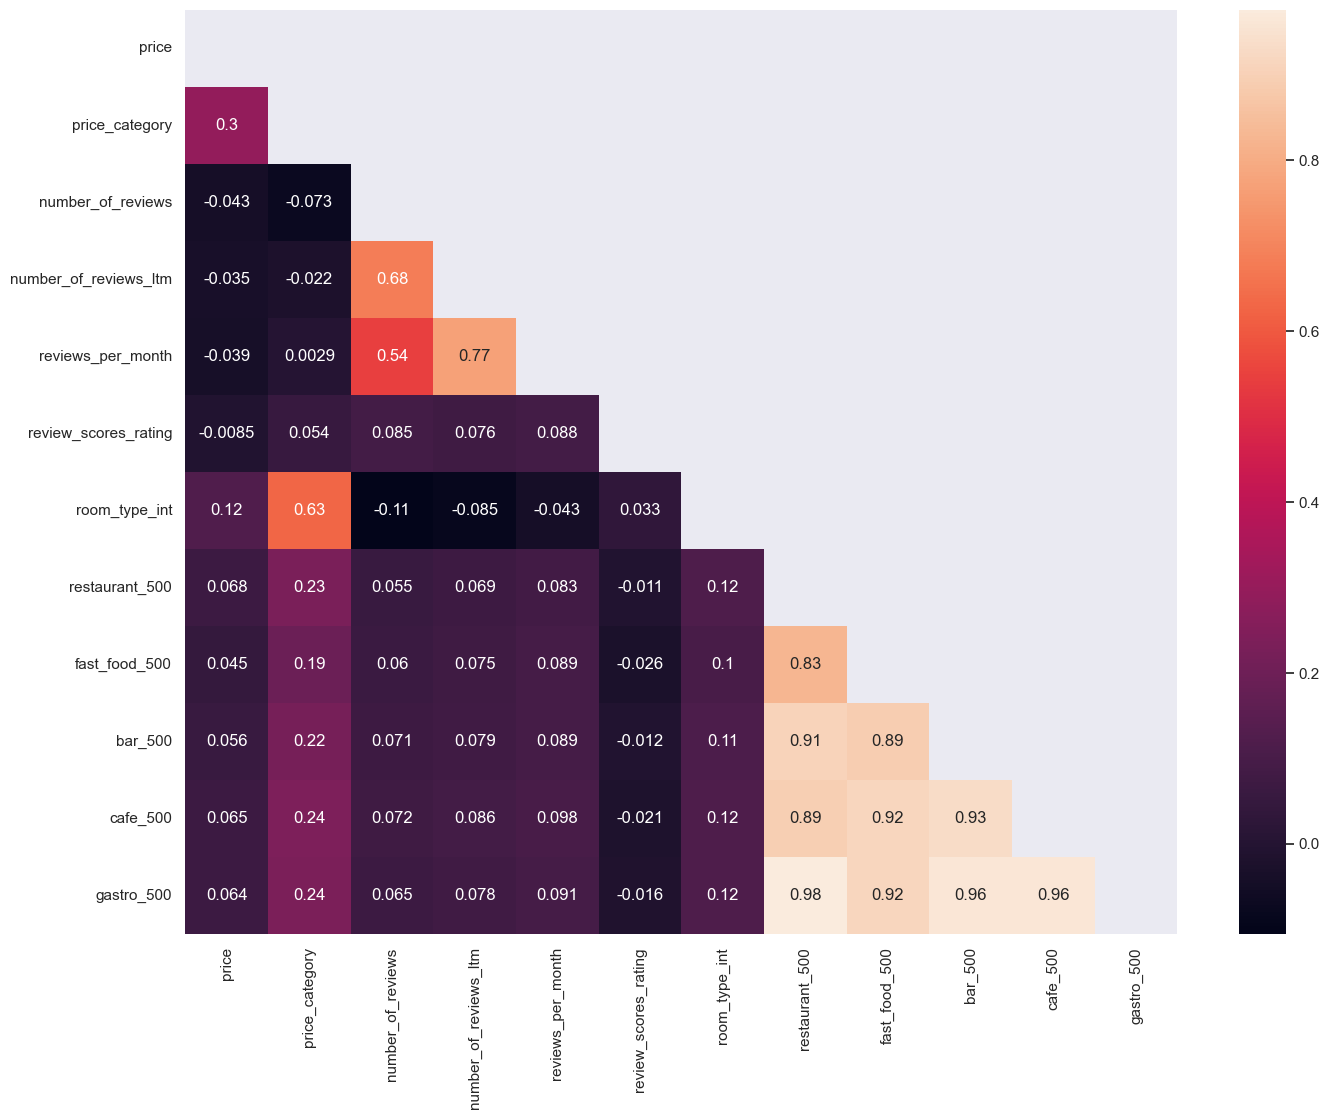

In [117]:
corr = heat.corr(numeric_only=True)

sns.set(rc={"figure.figsize":(16, 12)})

# getting the upper triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

### Hypothesis: In Area's with lot's of POI's, there are less Airbnb's which offer Entire Homes

In [118]:
# group by room_type_int and calculate the mean value 
poi.groupby(by="room_type_int").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean",
                                             "id": "size"})[["gastro_500","restaurant_500","fast_food_500","cafe_500", "bar_500", "id"]]

,gastro_500,restaurant_500,fast_food_500,cafe_500,bar_500,id
room_type_int,,,,,,
1,58.972705,24.446650,10.039702,14.071960,10.414392,403
2,46.056105,16.824836,9.064372,11.513836,8.653061,28910
3,83.144860,36.341121,13.121495,19.766355,13.915888,214
4,69.531916,28.539966,12.025156,16.241917,12.724876,45714


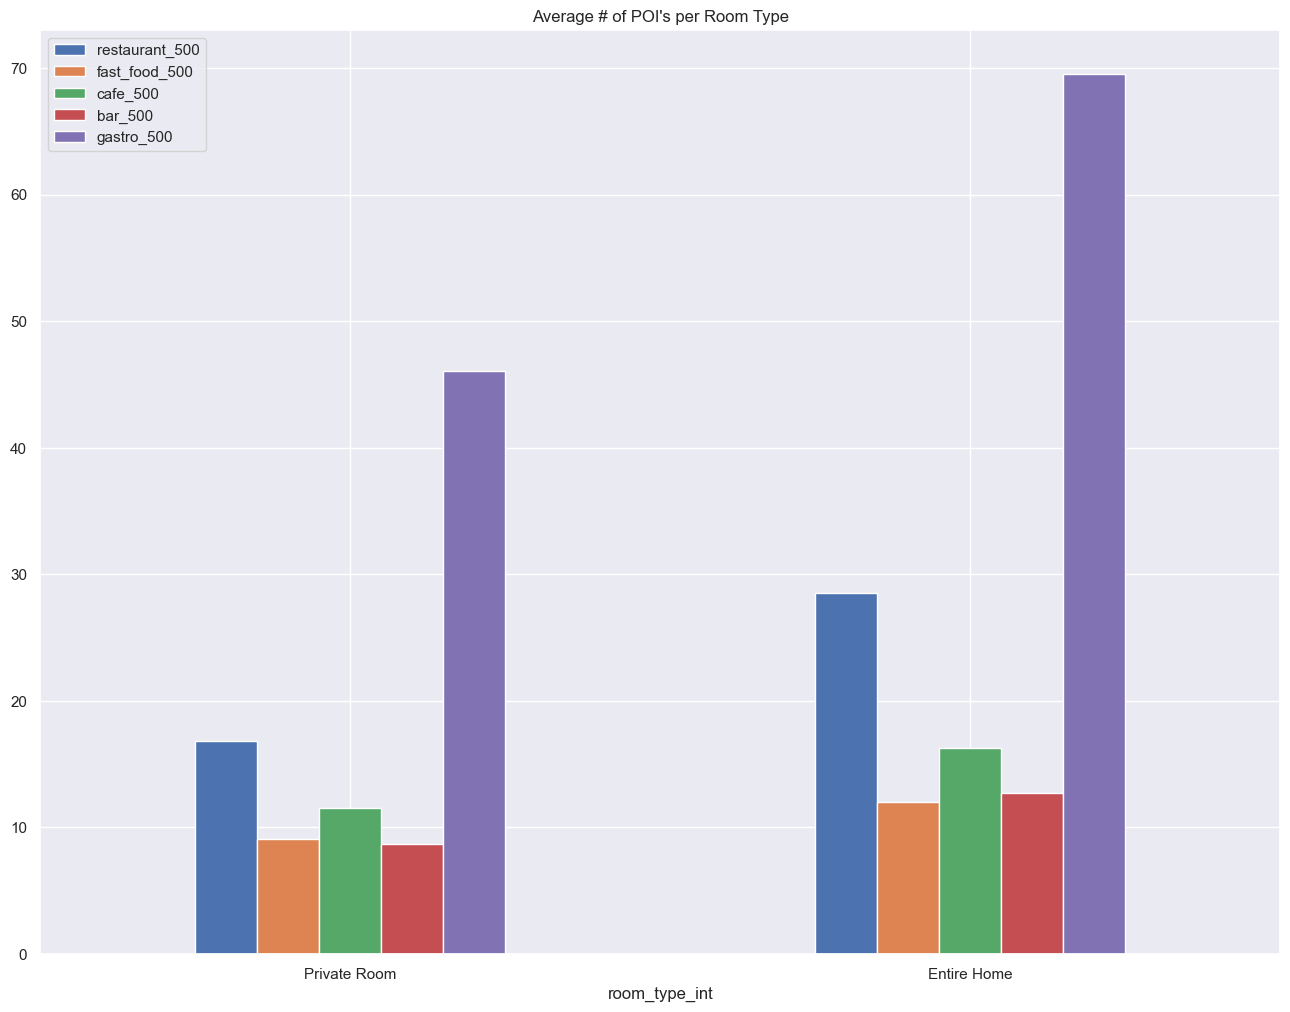

In [119]:
# plot without category "hotel room(3)" or "shared room (1)"
poi[(poi["room_type_int"] != 1) & (poi["room_type_int"] != 3)].groupby(by="room_type_int").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean"})[["restaurant_500","fast_food_500","cafe_500", "bar_500", "gastro_500"]].plot(kind="bar")
plt.xticks([0, 1], ["Private Room", "Entire Home"], rotation=360)
plt.title("Average # of POI's per Room Type")
plt.show()

### Hypothesis: POI's have direct impact on Price & Demand of Airbnb's

In [120]:
# group by price category and calculate the mean value 
poi.groupby(by="price_category").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean",
                                             "id": "size"})[["gastro_500","restaurant_500","fast_food_500","cafe_500", "bar_500", "id"]]

,gastro_500,restaurant_500,fast_food_500,cafe_500,bar_500,id
price_category,,,,,,
0,104.500000,41.500000,17.071429,24.571429,21.357143,14
1,34.917777,11.697025,7.668699,8.951561,6.600492,20335
2,48.950665,18.069826,9.522691,12.091263,9.266886,17959
3,63.143402,24.581080,11.415265,15.240312,11.906745,18605
4,97.458479,43.017460,15.224902,21.943584,17.272534,18328


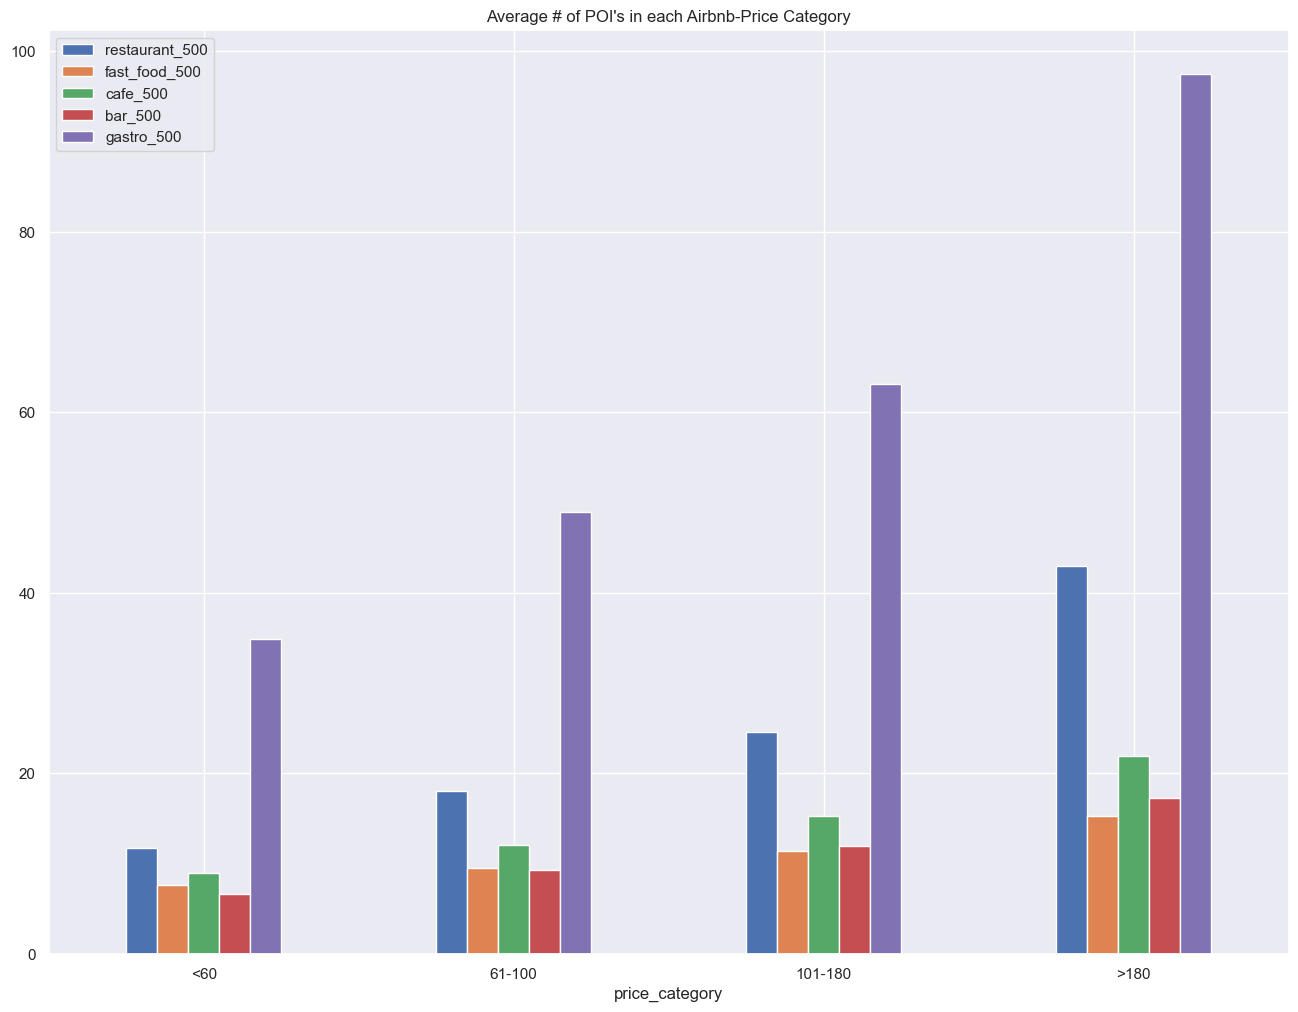

In [121]:
# plot without category 0 
poi[poi["price_category"] != 0].groupby(by="price_category").agg({"gastro_500": "mean", 
                                             "restaurant_500": "mean",
                                             "fast_food_500": "mean",
                                             "cafe_500": "mean",
                                             "bar_500": "mean"})[["restaurant_500","fast_food_500","cafe_500", "bar_500", "gastro_500"]].plot(kind="bar")

plt.xticks([0, 1, 2, 3], ["<60", "61-100", "101-180", ">180"], rotation=360)
plt.title("Average # of POI's in each Airbnb-Price Category")
plt.show()

### Hypothesis: More POI's == better reviews (for location & general)

### Rating vs. Gastro POI's vs. Price Category

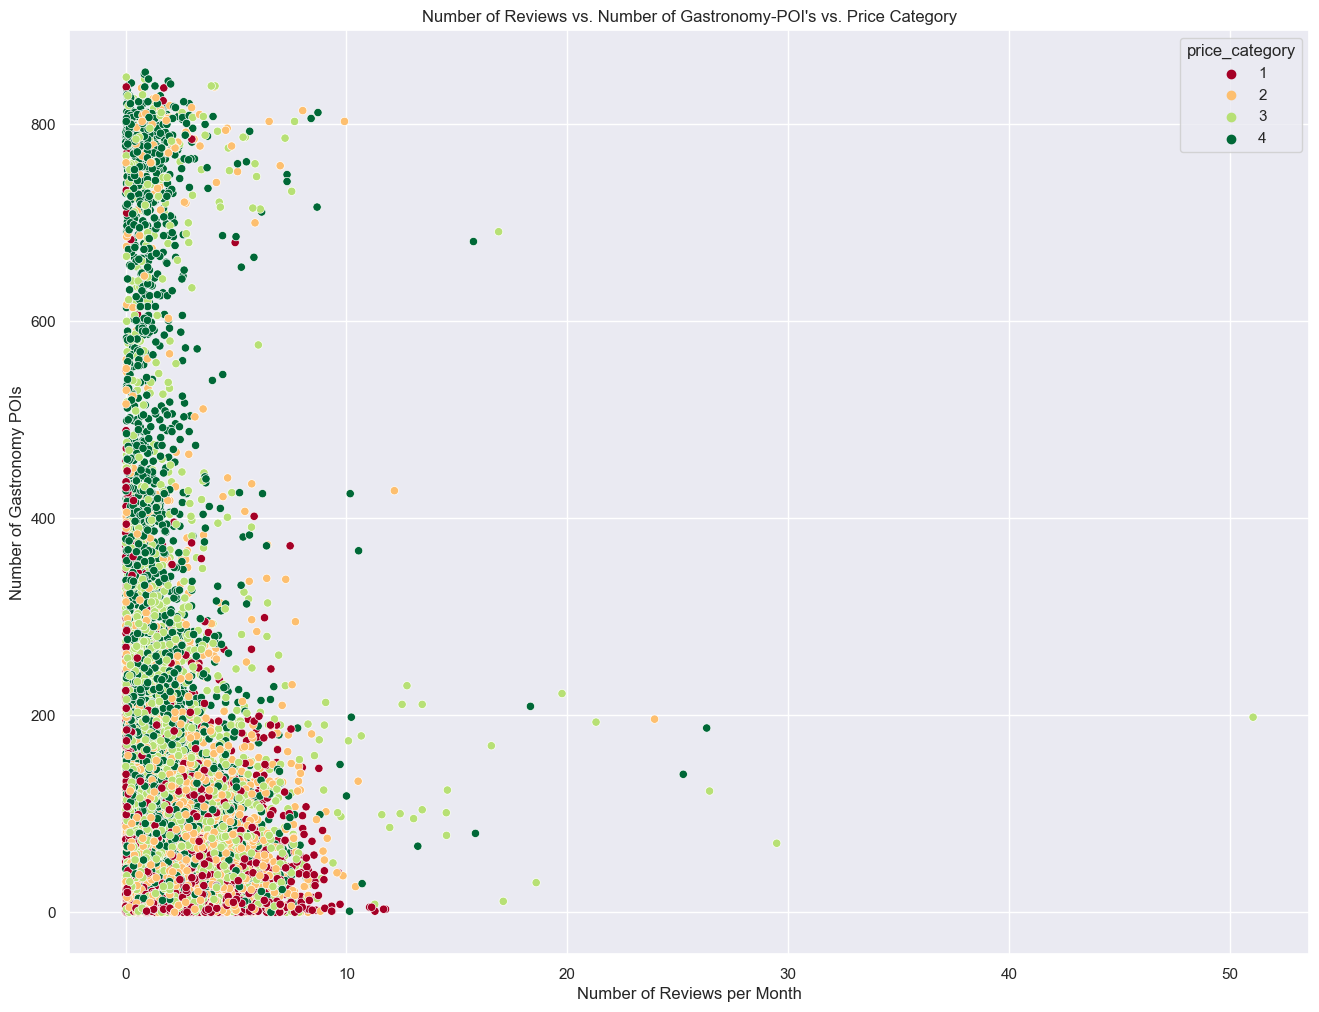

In [122]:
sns.set(rc={"figure.figsize":(16, 12)})

# Filter only Reviews with > 0 Reviews per Month, without Category 0
poi_gastro_filtered = poi[(poi["reviews_per_month"] > 0) & (poi["price_category"] > 0)]

# Define the red-green color palette
custom_palette = sns.color_palette("RdYlGn", as_cmap=True)

# Create the scatter plot with hue based on review_scores_rating
ax = sns.scatterplot(x="reviews_per_month", y="gastro_500", hue="price_category", data=poi_gastro_filtered, palette=custom_palette)

# Rename the x-axis and y-axis labels
ax.set_xlabel("Number of Reviews per Month")
ax.set_ylabel("Number of Gastronomy POIs")

plt.title("Number of Reviews vs. Number of Gastronomy-POI's vs. Price Category")
plt.show()

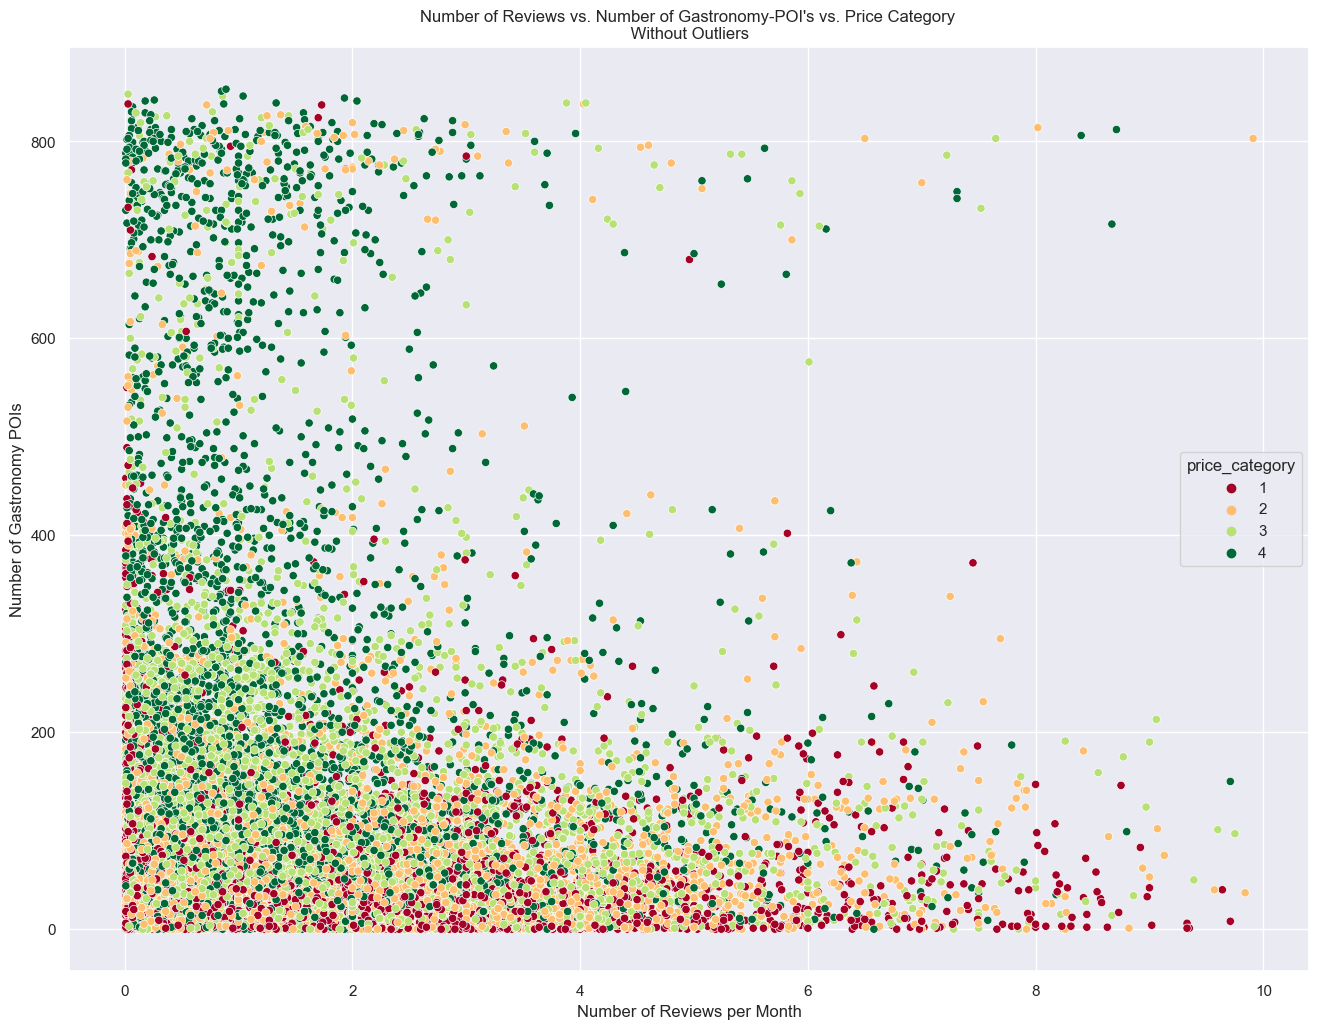

In [123]:
sns.set(rc={"figure.figsize":(16, 12)})

# Filter only Reviews with > 0 Reviews per Month, without Category 0, and without outliers
poi_gastro_filtered = poi[(poi["reviews_per_month"] > 0) & (poi["reviews_per_month"] < 10) & (poi["price_category"] > 0)]

# Define the red-green color palette
custom_palette = sns.color_palette("RdYlGn", as_cmap=True)

# Create the scatter plot with hue based on review_scores_rating
ax = sns.scatterplot(x="reviews_per_month", y="gastro_500", hue="price_category", data=poi_gastro_filtered, palette=custom_palette)

# Rename the x-axis and y-axis labels
ax.set_xlabel("Number of Reviews per Month")
ax.set_ylabel("Number of Gastronomy POIs")

plt.title("Number of Reviews vs. Number of Gastronomy-POI's vs. Price Category \n Without Outliers ")
plt.show()

### Hypothesis: Certain Amenities have direct impact on Price & Demand of Airbnb's

In [125]:
#Correlation between price & amenities 

columns = ['private_bath', 'wifi', 'long_term_stays_allowed',
       'private_patio_or_balcony', 'private_entrance', 'pets_allowed',
       'outdoor_dining_area', 'lockbox', 'kitchen', 'hair_dryer',
       'free_street_parking', 'free_parking_on_premises',
       'dedicated_workspace', 'coffee', 'bed_linens',
       'bathtub']


selected_columns = poi[columns]
corr = selected_columns.corrwith(poi["price_category"]).sort_values(ascending=False)

print(corr)

private_bath                0.513564
bed_linens                  0.218300
bathtub                     0.213435
long_term_stays_allowed     0.204076
private_entrance            0.189065
coffee                      0.175759
dedicated_workspace         0.175733
private_patio_or_balcony    0.161972
hair_dryer                  0.157112
lockbox                     0.125381
kitchen                     0.106456
outdoor_dining_area         0.106022
pets_allowed                0.077965
wifi                        0.005614
free_parking_on_premises   -0.089947
free_street_parking        -0.092478
dtype: float64


(-0.1, 0.5)

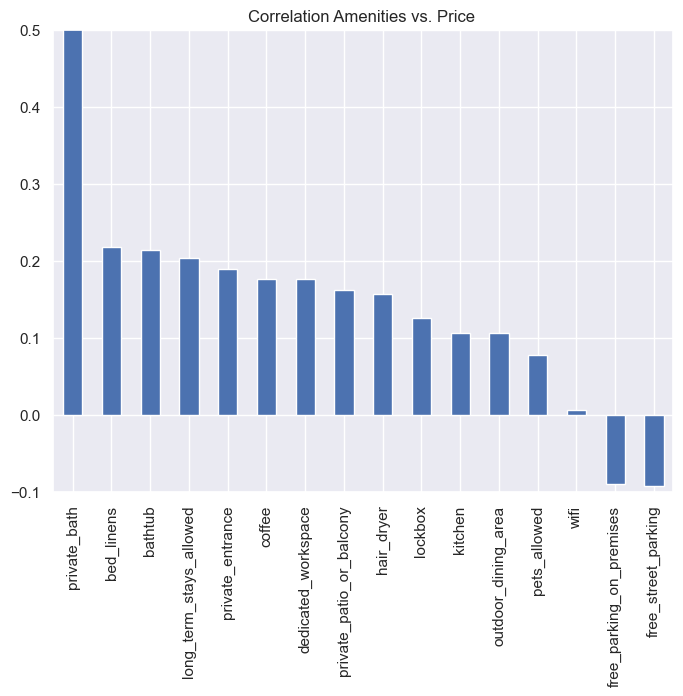

In [126]:
plt.figure(figsize=(8, 6))

corr.plot(kind="bar")
plt.title("Correlation Amenities vs. Price ")

plt.ylim(-0.1, 0.5)

In [128]:
#Correlation between amenities & reviews 

columns = ['private_bath', 'wifi', 'long_term_stays_allowed',
       'private_patio_or_balcony', 'private_entrance', 'pets_allowed',
       'outdoor_dining_area', 'lockbox', 'kitchen', 'hair_dryer',
       'free_street_parking', 'free_parking_on_premises',
       'dedicated_workspace', 'coffee', 'bed_linens',
       'bathtub']


selected_columns = poi[columns]
corr = selected_columns.corrwith(poi["review_scores_rating"]).sort_values(ascending=False)

print(corr)

coffee                      0.139067
bed_linens                  0.116058
hair_dryer                  0.116018
bathtub                     0.111249
private_patio_or_balcony    0.100943
dedicated_workspace         0.094047
outdoor_dining_area         0.092537
free_street_parking         0.071810
lockbox                     0.063410
long_term_stays_allowed     0.059237
private_entrance            0.038701
kitchen                     0.017065
private_bath                0.004981
pets_allowed                0.004042
free_parking_on_premises   -0.001515
wifi                       -0.023244
dtype: float64


(-0.1, 0.5)

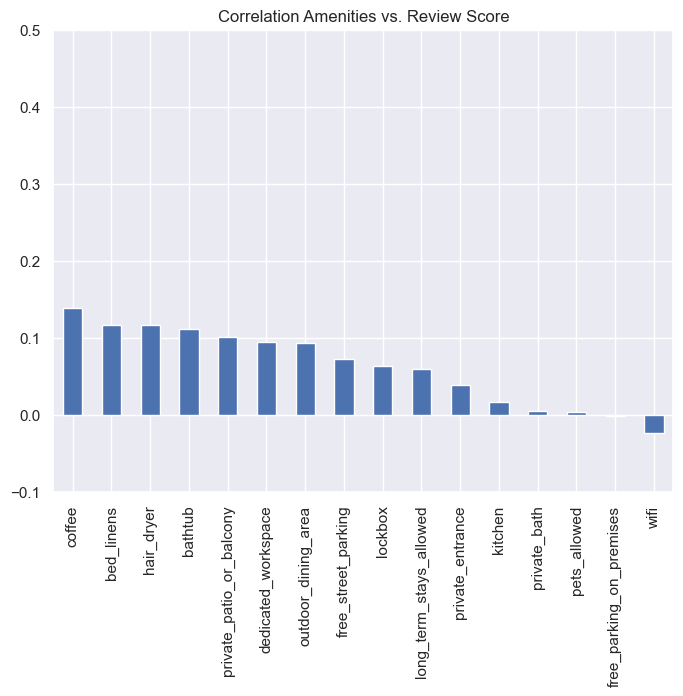

In [129]:
plt.figure(figsize=(8, 6))

corr.plot(kind="bar")
plt.title("Correlation Amenities vs. Review Score")

plt.ylim(-0.1, 0.5)

## Calculation in Python

didnt work properly. still has to be checked

### POI in Area

In [130]:
# ### subset's of df's for each amenity 
# restaurant = osm_short[osm_short["amenity"] == "restaurant"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# fast_food = osm_short[osm_short["amenity"] == "fast_food"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# cafe = osm_short[osm_short["amenity"] == "cafe"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# bar = osm_short[osm_short["amenity"] == "bar"][['id', 'latitude', 'longitude', 'name', 'amenity']]
# subway = osm_short[osm_short["railway"] == "subway_entrance"][['id', 'latitude', 'longitude', 'name', 'railway']]

# street_test = osm_short[["id", "latitude", "longitude", "amenity"]]

In [131]:
# airbnb_short = airbnb[['id', 'latitude', 'longitude']]

#### Function meters_to_degrees

In [132]:
# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(
#         proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)

#     # Calculate the distance per degree of latitude
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(
#         4 * math.radians(latitude)) - 0.0023 * math.cos(6 * math.radians(latitude))

#     # Calculate the distance per degree of longitude
#     lon_dist_per_deg = math.pi / 180 * 6378137 * \
#         math.cos(math.radians(latitude))

#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees

### 100 Meter

In [133]:
# # ignore seetingswithcopy only for this cell. will be set back to warn at the end of the code
# pd.options.mode.chained_assignment = None

# # Convert the airbnb_short DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_geo = gpd.GeoDataFrame(airbnb_short, geometry=gpd.points_from_xy( airbnb_short["longitude"], airbnb_short["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an array of coordinates for the street_test GeoDataFrame
# X = np.column_stack((street_test_geo["longitude"].values, street_test_geo["latitude"].values))

# # Create a BallTree spatial index for the street_test GeoDataFrame
# tree = BallTree(X, leaf_size=40)

# # Define the radius of the search in meters
# radius_meters = 100

# # Loop through each row in airbnb_geo
# for index, row in airbnb_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)

#     # Use the BallTree spatial index to find the street_test rows within the search radius
#     indices = tree.query_radius([[row["longitude"], row["latitude"]]], r=lon_deg)[0]

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[indices]

#     # Count the occurrences of each amenity in the candidate rows
#     counts = candidate_rows["amenity"].value_counts().to_dict()

#     # Add the counts as new columns in the airbnb_short DataFrame
#     for amenity_type, count in counts.items():
#         airbnb_short.at[index, amenity_type] = count

# #    # Add the list of ids as a new column in the airbnb_short
# #    airbnb_short.at[index, "street_test_ids"] = str(candidate_rows["id"].tolist())

#     # If there are no amenities in the given radius, append "no amenities" in the list of ids
# #    if not candidate_rows["id"].tolist():
# #        airbnb_short.at[index, "street_test_ids"] = "no amenities"

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # Replace NaN values with 0
# airbnb_short.fillna(value=0, inplace=True)

# pd.options.mode.chained_assignment = 'warn'

### Nearest distance 

In [134]:
# ### is calculating values, but they seem to small
# from scipy.spatial import cKDTree

# # Import the radians function from numpy
# from numpy import radians

# # Convert the latitude and longitude columns in both dataframes to radians
# airbnb[['latitude', 'longitude']] = radians(airbnb[['latitude', 'longitude']])
# subway[['latitude', 'longitude']] = radians(subway[['latitude', 'longitude']])

# # Build the KDTree index using the radians converted latitude and longitude columns in the subway dataframe
# subway_tree = cKDTree(subway[['latitude', 'longitude']])

# # Query the KDTree index for the nearest subway station to each airbnb location
# distances, indices = subway_tree.query(airbnb[['latitude', 'longitude']], k=1)

# # Convert the distance from radians to meters
# earth_radius = 6371000  # radius of the Earth in meters
# distances_meters = distances * earth_radius

# # Add the nearest subway station distance to each airbnb row
# airbnb['nearest_subway_distance'] = distances_meters



In [135]:
#airbnb['nearest_subway_distance'].describe()

## Old

In [136]:
# ### runs, but with too smal results 

# # ignore seetingswithcopy only for this cell. will be set back to warn at the end of the code 
# pd.options.mode.chained_assignment = None

# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(4 * math.radians(latitude))
#     lon_dist_per_deg = 111412.84 * math.cos(math.radians(latitude))
#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees


# airbnb_test["closest_amenity"] = ""


# # Convert the airbnb_test DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_test_geo = gpd.GeoDataFrame(airbnb_test, geometry=gpd.points_from_xy(airbnb_test["longitude"], airbnb_test["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an R-tree spatial index for the street_test GeoDataFrame
# street_test_sindex = street_test_geo.sindex

# # Define the radius of the search in meters
# radius_meters = 1_000

# # Loop through each row in airbnb_test_geo
# for index, row in airbnb_test_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)
    
#     # Use the R-tree spatial index to find the street_test rows within the search radius
#     candidate_indices = list(street_test_sindex.intersection(row.geometry.buffer(lon_deg).bounds))

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[candidate_indices]
# #
#     if len(candidate_rows) == 0:
#         # No amenities within the search radius
#         closest_amenity_distance = np.nan
#     else:
#         # Calculate the distances from the current Airbnb location to all the amenities in the search radius
#         candidate_rows["distance"] = candidate_rows.geometry.distance(row.geometry)

#         # Sort the candidate rows by distance
#         candidate_rows = candidate_rows.sort_values("distance")

#         # Find the closest amenity and its distance
#         closest_amenity = candidate_rows["amenity"].iloc[0]
#         closest_amenity_distance = candidate_rows["distance"].iloc[0]

#     # Add the closest amenity and its distance as new columns in the airbnb_test DataFrame
#     airbnb_test.at[index, "closest_amenity"] = closest_amenity
#     airbnb_test.at[index, "closest_amenity_distance_m"] = closest_amenity_distance

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # set seetingswithcopy back only for this cell. will be set back to warn at the end of the code 
# pd.options.mode.chained_assignment = 'warn'


In [137]:
#airbnb_test.describe()

In [138]:
# ### runs, but with less accurate results, than in 4.1.

# ### Number of amenities + liste 

# import geopandas as gpd
# from shapely.geometry import Point
# from shapely.ops import transform
# from functools import partial
# import pyproj
# import math

# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(
#         proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)

#     # Calculate the distance per degree of latitude
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(
#         4 * math.radians(latitude)) - 0.0023 * math.cos(6 * math.radians(latitude))

#     # Calculate the distance per degree of longitude
#     lon_dist_per_deg = math.pi / 180 * 6378137 * \
#         math.cos(math.radians(latitude))

#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees


# # Convert the airbnb_test DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_test_geo = gpd.GeoDataFrame(airbnb_test, geometry=gpd.points_from_xy(airbnb_test["longitude"], airbnb_test["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an R-tree spatial index for the street_test GeoDataFrame
# street_test_sindex = street_test_geo.sindex

# # Define the radius of the search in meters
# radius_meters = 200

# # Loop through each row in airbnb_test_geo
# for index, row in airbnb_test_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)
    
#     # Use the R-tree spatial index to find the street_test rows within the search radius
#     candidate_indices = list(street_test_sindex.intersection(row.geometry.buffer(lon_deg).bounds))

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[candidate_indices]

#     # Create an empty list to store the id's of street_test rows
#     ids = []

#     # Group the candidate rows by amenity and count the occurrences
#     counts = candidate_rows.groupby("amenity").size().to_dict()

#     # Add the counts as new columns in the airbnb_test DataFrame
#     for amenity_type, count in counts.items():
#         airbnb_test.at[index, amenity_type] = count
#         ids.extend(candidate_rows[candidate_rows["amenity"] == amenity_type]["id"].tolist())

#     # If there are no amenities in the given radius, append "no amenities" in the list of ids
#     if not ids:
#         ids.append("no amenities")
        
#     # Add the list of ids as a new column in the airbnb_test DataFrame
#     airbnb_test.at[index, "street_test_ids"] = str(ids)

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # Replace NaN values with 0
# airbnb_test.fillna(value=0, inplace=True)



In [139]:
# ### Calculation of POI's in Area with Balltree (old, not working properly)

# # Calculate the needed radius when converted to unit sphere.
# distance_in_meter = 200
# earth_radius_in_meter = 6_371_000

# radius = distance_in_meter / earth_radius_in_meter

# # Convert the latitude and longitude columns to radians
# airbnb_test = airbnb_test.copy()
# airbnb_test.loc[:, 'lat_rad'] = np.radians(airbnb_test['latitude'])
# airbnb_test.loc[:, 'lon_rad'] = np.radians(airbnb_test['longitude'])
# street_test = street_test.copy()
# street_test.loc[:, 'lat_rad'] = np.radians(street_test['latitude'])
# street_test.loc[:, 'lon_rad'] = np.radians(street_test['longitude'])

# # Create a BallTree object with the latitude and longitude columns
# tree = BallTree(street_test[['lat_rad', 'lon_rad']],
#                 leaf_size=15, metric='haversine')

# # Find the indices of all neighbors within a radius of 500 meters
# # for each row in list_test
# indices = tree.query_radius(
#     airbnb_test[['lat_rad', 'lon_rad']], r=radius, count_only=False)

# # Calculate the number of neighbors for each amenity type
# amenity_types = street_test['amenity'].unique()
# amenity_counts = np.zeros((airbnb_test.shape[0], amenity_types.shape[0]))
# for i, amenity in enumerate(amenity_types):
#     street_indices = street_test[street_test['amenity'] == amenity].index
#     intersection_counts = np.array(
#         [np.intersect1d(street_indices, idx).size for idx in indices])
#     amenity_counts[:, i] = intersection_counts

# # Add the new columns to list_test
# list_test = pd.concat([airbnb_test, pd.DataFrame(amenity_counts, columns=[
#                       f'num_neighbors_{amenity}' for amenity in amenity_types])], axis=1)

# # Calculate the number of neighbors for each railway type
# railway_types = street_test['railway'].unique()
# railway_counts = np.zeros((list_test.shape[0], railway_types.shape[0]))
# for i, railway in enumerate(railway_types):
#     street_indices = street_test[street_test['railway'] == railway].index
#     intersection_counts = np.array(
#         [np.intersect1d(street_indices, idx).size for idx in indices])
#     railway_counts[:, i] = intersection_counts

# # Add the new columns to list_test
# list_test = pd.concat([list_test, pd.DataFrame(railway_counts, columns=[
#                       f'num_neighbors_{railway}' for railway in railway_types])], axis=1)


# # Remove the temporary columns
# list_test.drop(columns=['lat_rad', 'lon_rad'], inplace=True)
# street_test.drop(columns=['lat_rad', 'lon_rad'], inplace=True)


### Nearest Station-old

In [140]:
# from haversine import haversine, Unit

# # define a function to calculate distance between two points
# def calc_distance(lat1, lon1, lat2, lon2):
#     return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)

# # get all unique values in "tags.railway" that are present in airbnb
# railway_tags = airbnb["railway"].unique()

# # loop through each row in airbnb and calculate the minimum distance
# # for each value in airbnb["railway"]
# for tag in railway_tags:
#     distances = []
#     for _, row in airbnb[airbnb["railway"] == tag].iterrows():
#         min_distance = None
#         for _, sm_row in osm_short[osm_short["railway"] == tag].iterrows():
#             distance = calc_distance(row["latitude"], row["longitude"], sm_row["latitude"], sm_row["longitude"])
#             if min_distance is None or distance < min_distance:
#                 min_distance = distance
#         distances.append(min_distance)

#     # add the calculated minimum distances as a new column in airbnb
#     col_name = "min_distance_{}".format(tag)
#     airbnb.loc[airbnb["railway"] == tag, col_name] = distances


In [141]:
# from haversine import haversine, Unit

# # define a function to calculate distance between two points
# def calc_distance(lat1, lon1, lat2, lon2):
#     return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)

# # only one value in "tags.railway", so use it directly in the loop
# tag = "restaurant"

# distances = []
# for _, row in airbnb.iterrows():
#     min_distance = None
#     for _, sm_row in osm_short[osm_short["amenity"] == tag].iterrows():
#         distance = calc_distance(row["latitude"], row["longitude"], sm_row["latitude"], sm_row["longitude"])
#         if min_distance is None or distance < min_distance:
#             min_distance = distance
#     distances.append(min_distance)

# # add the calculated minimum distances as a new column in airbnb
# col_name = "min_distance_{}".format(tag)
# airbnb[col_name] = distances
